## Data Analysis of covid_cases.csv dataset

#### Libraries and Spark Session

In [36]:
# Libraries
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.functions import col, max
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as seab


# Creating a spark session
spark = SparkSession.builder.appName('covid').getOrCreate()

#### Exploring the dataset COVID Cases Dataset

In [37]:

# Reading the dataset with spark
dfs_cc = spark.read.csv('./datasets/covid_cases_upd.csv', header=True, inferSchema=True)

# Printing the dataset size
print(f'Dataset size: \nRows: {dfs_cc.count()} and Columns: {len(dfs_cc.columns)}')

# Printing column names
print('\nColumn names:\n')
spark.createDataFrame(dfs_cc.columns, 'string').show(len(dfs_cc.columns), truncate=False)

# Printing the schema
dfs_cc.printSchema()

# Printing the first 5 rows
dfs_cc.show(5)

# Filtering continents column to print only the continents and turning spark dataset to RDD to use lambda functions
print('\nContinents:')
uni_continent = dfs_cc.select('continent')\
                    .distinct()\
                    .rdd.flatMap(lambda x: x)\
                    .filter(lambda x: x is not None)\
                    .collect()
print(uni_continent)
print(f'Number of Continents: {len(uni_continent)}')

# Filtering location column to print only the countries and turning spark datase to RDD to use l
print('\nCountries:')
uni_country = dfs_cc.select('location')\
                    .distinct()\
                    .sort('location', ascending=True)\
                    .rdd.flatMap(lambda x: x)\
                    .filter(lambda x: x is not None and x not in uni_continent)\
                    .collect()
print(uni_country)
print(f'Number of Countries: {len(uni_country)}\n')

# Printing the number of data points for each country
print('Number of data points for each country:')
dfs_cc.groupBy('location').count().show()

# Printing the avarage number of data points for all countries
print('Avarage number of data points for all countries:')
dfs_cc.groupBy('location').count().agg({'count': 'avg'}).show()


Dataset size: 
Rows: 349999 and Columns: 67

Column names:

+------------------------------------------+
|value                                     |
+------------------------------------------+
|iso_code                                  |
|continent                                 |
|location                                  |
|date                                      |
|total_cases                               |
|new_cases                                 |
|new_cases_smoothed                        |
|total_deaths                              |
|new_deaths                                |
|new_deaths_smoothed                       |
|total_cases_per_million                   |
|new_cases_per_million                     |
|new_cases_smoothed_per_million            |
|total_deaths_per_million                  |
|new_deaths_per_million                    |
|new_deaths_smoothed_per_million           |
|reproduction_rate                         |
|icu_patients                           

#### Ploting accomulative cases of United States, Brazil, Italy, Australia, and New Zealand

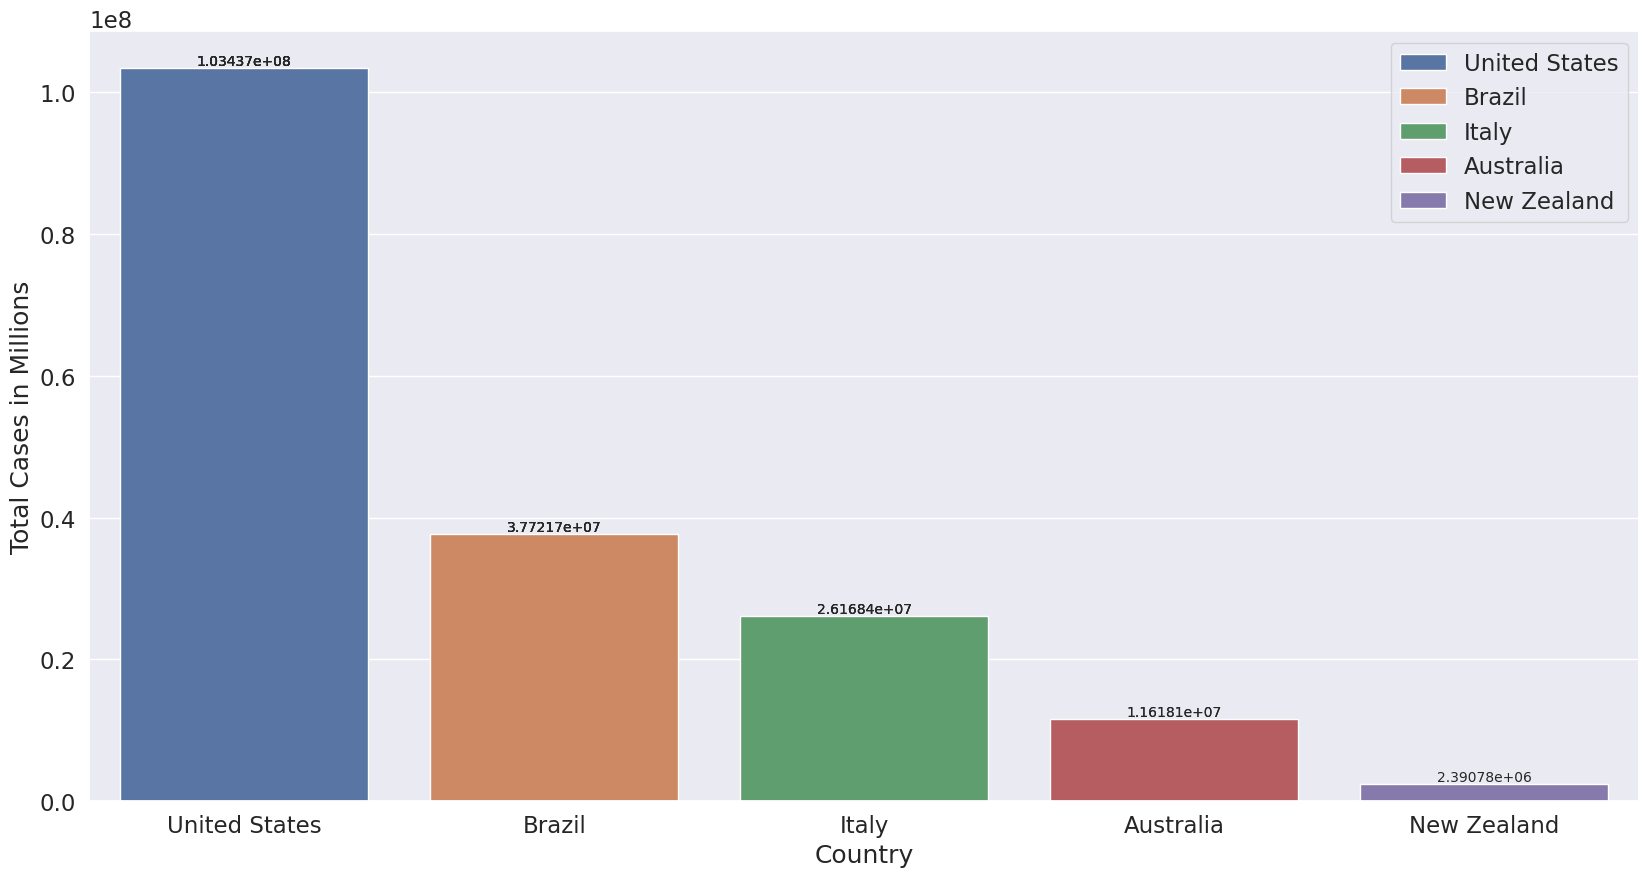

In [52]:
dataset_countries_comulative = {
    'United States': dfs_cc.filter(col('location') == 'United States'),
    'Brazil': dfs_cc.filter(col('location') == 'Brazil'),
    'Italy': dfs_cc.filter(col('location') == 'Italy'),
    'Australia': dfs_cc.filter(col('location') == 'Australia'),
    'New Zealand': dfs_cc.filter(col('location') == 'New Zealand')
}

seab.set(font_scale=1.5, rc={'figure.figsize':(20, 10)})

# Plotting the number of cases for each country
for country, dataset in dataset_countries_comulative.items():
    max_cases = dataset.agg(max('total_cases')).collect()[0][0]
    ax = seab.barplot(x=[country], y=[max_cases], label=f'{country}')
    for container in ax.containers:
        ax.bar_label(container, fontsize=10)

# plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Country')
plt.ylabel('Total Cases in Millions')
plt.show()

#### Community Mobility with Europen Countrines
##### Countries: Italy, France, Germany, Spain, United Kingdom, Finland, Poland, and Slovakia.

+---------------------+
|value                |
+---------------------+
|Entity               |
|Code                 |
|Day                  |
|retail_and_recreation|
|grocery_and_pharmacy |
|residential          |
|transit_stations     |
|parks                |
|workplaces           |
+---------------------+



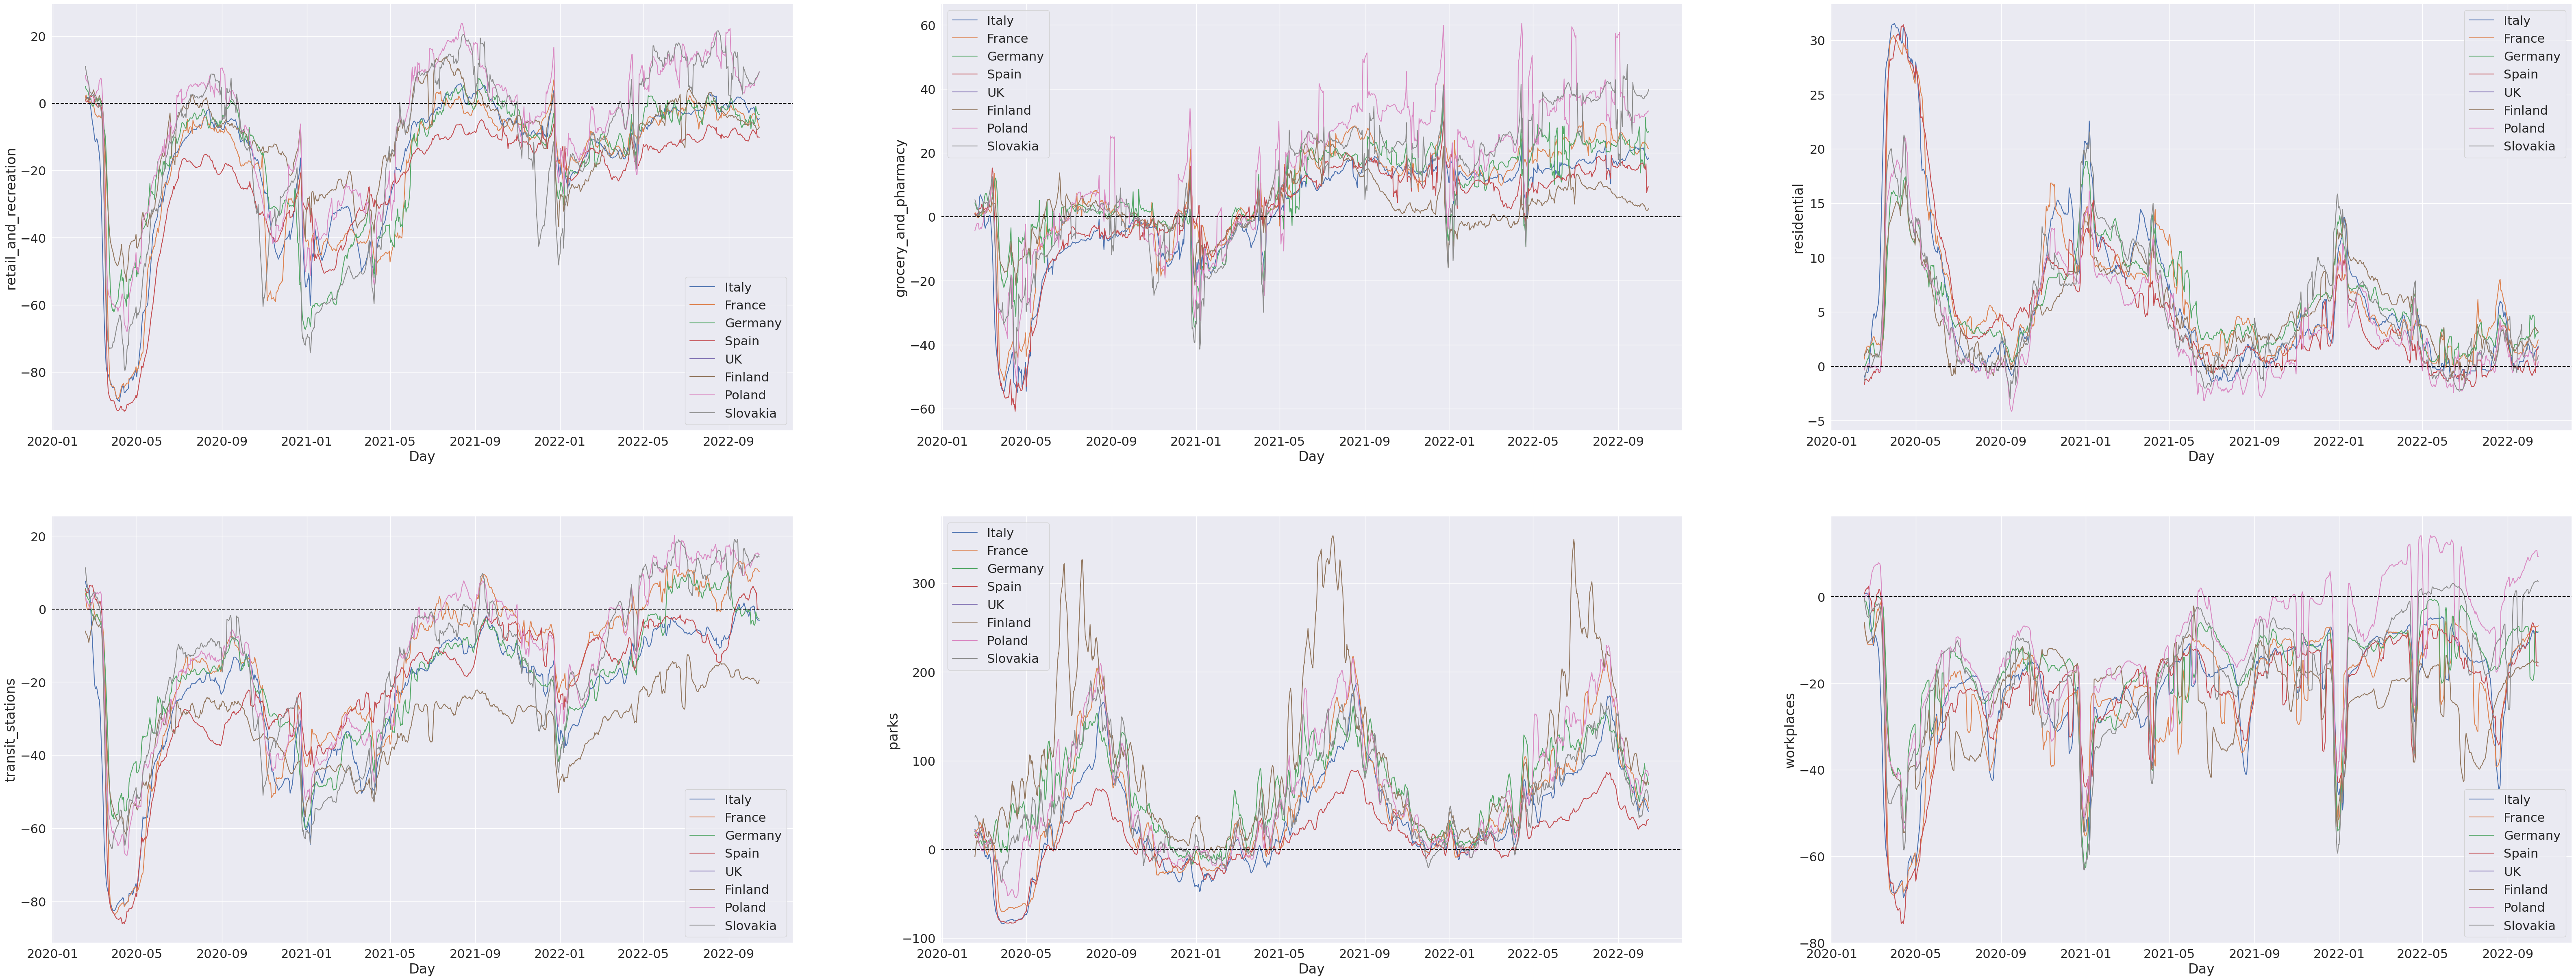

In [2]:
# Smoothed dataset spand from 2020-02-17 to 2022-10-15
# Source: https://ourworldindata.org/covid-google-mobility-trends
df_mobility_global_smo = spark.read.csv('./datasets/changes-visitors-covid.csv', header=True, inferSchema=True)

# Printing the columns of Community Mobility dataset smoothed by 7 days
spark.createDataFrame(df_mobility_global_smo.columns, 'string').show(len(df_mobility_global_smo.columns), truncate=False)

# Few general European countries
dataset_countries = {
    "Italy": df_mobility_global_smo.filter((col('Entity') == 'Italy')),
    "France": df_mobility_global_smo.filter((col('Entity') == 'France')),
    "Germany": df_mobility_global_smo.filter((col('Entity') == 'Germany')),
    "Spain": df_mobility_global_smo.filter((col('Entity') == 'Spain')),
    "UK": df_mobility_global_smo.filter((col('Entity') == 'UK')),
    "Finland": df_mobility_global_smo.filter((col('Entity') == 'Finland')),
    "Poland": df_mobility_global_smo.filter((col('Entity') == 'Poland')),
    "Slovakia": df_mobility_global_smo.filter((col('Entity') == 'Slovakia'))
}

seab.set(font_scale=2)

figg, axx = plt.subplots(2, 3, figsize=(80, 30))

# Plotting the mobility data for few general European countries
plot_mobil_country_row = 0
plot_mobil_country_col = 0
for place in df_mobility_global_smo.columns[3:]:
    if plot_mobil_country_col == 3:
        plot_mobil_country_col = 0
        plot_mobil_country_row = 1
        
    for country, df_mob_glo_smo in dataset_countries.items():
        seab.lineplot(x='Day', y=place, data=dataset_countries[country].toPandas(), ax=axx[plot_mobil_country_row, plot_mobil_country_col], label=country)
        
    axx[plot_mobil_country_row, plot_mobil_country_col].axhline(y=0, color='black', linestyle='--')
    plot_mobil_country_col += 1

plt.show()

#### Mobility Australia vs New Zeeland

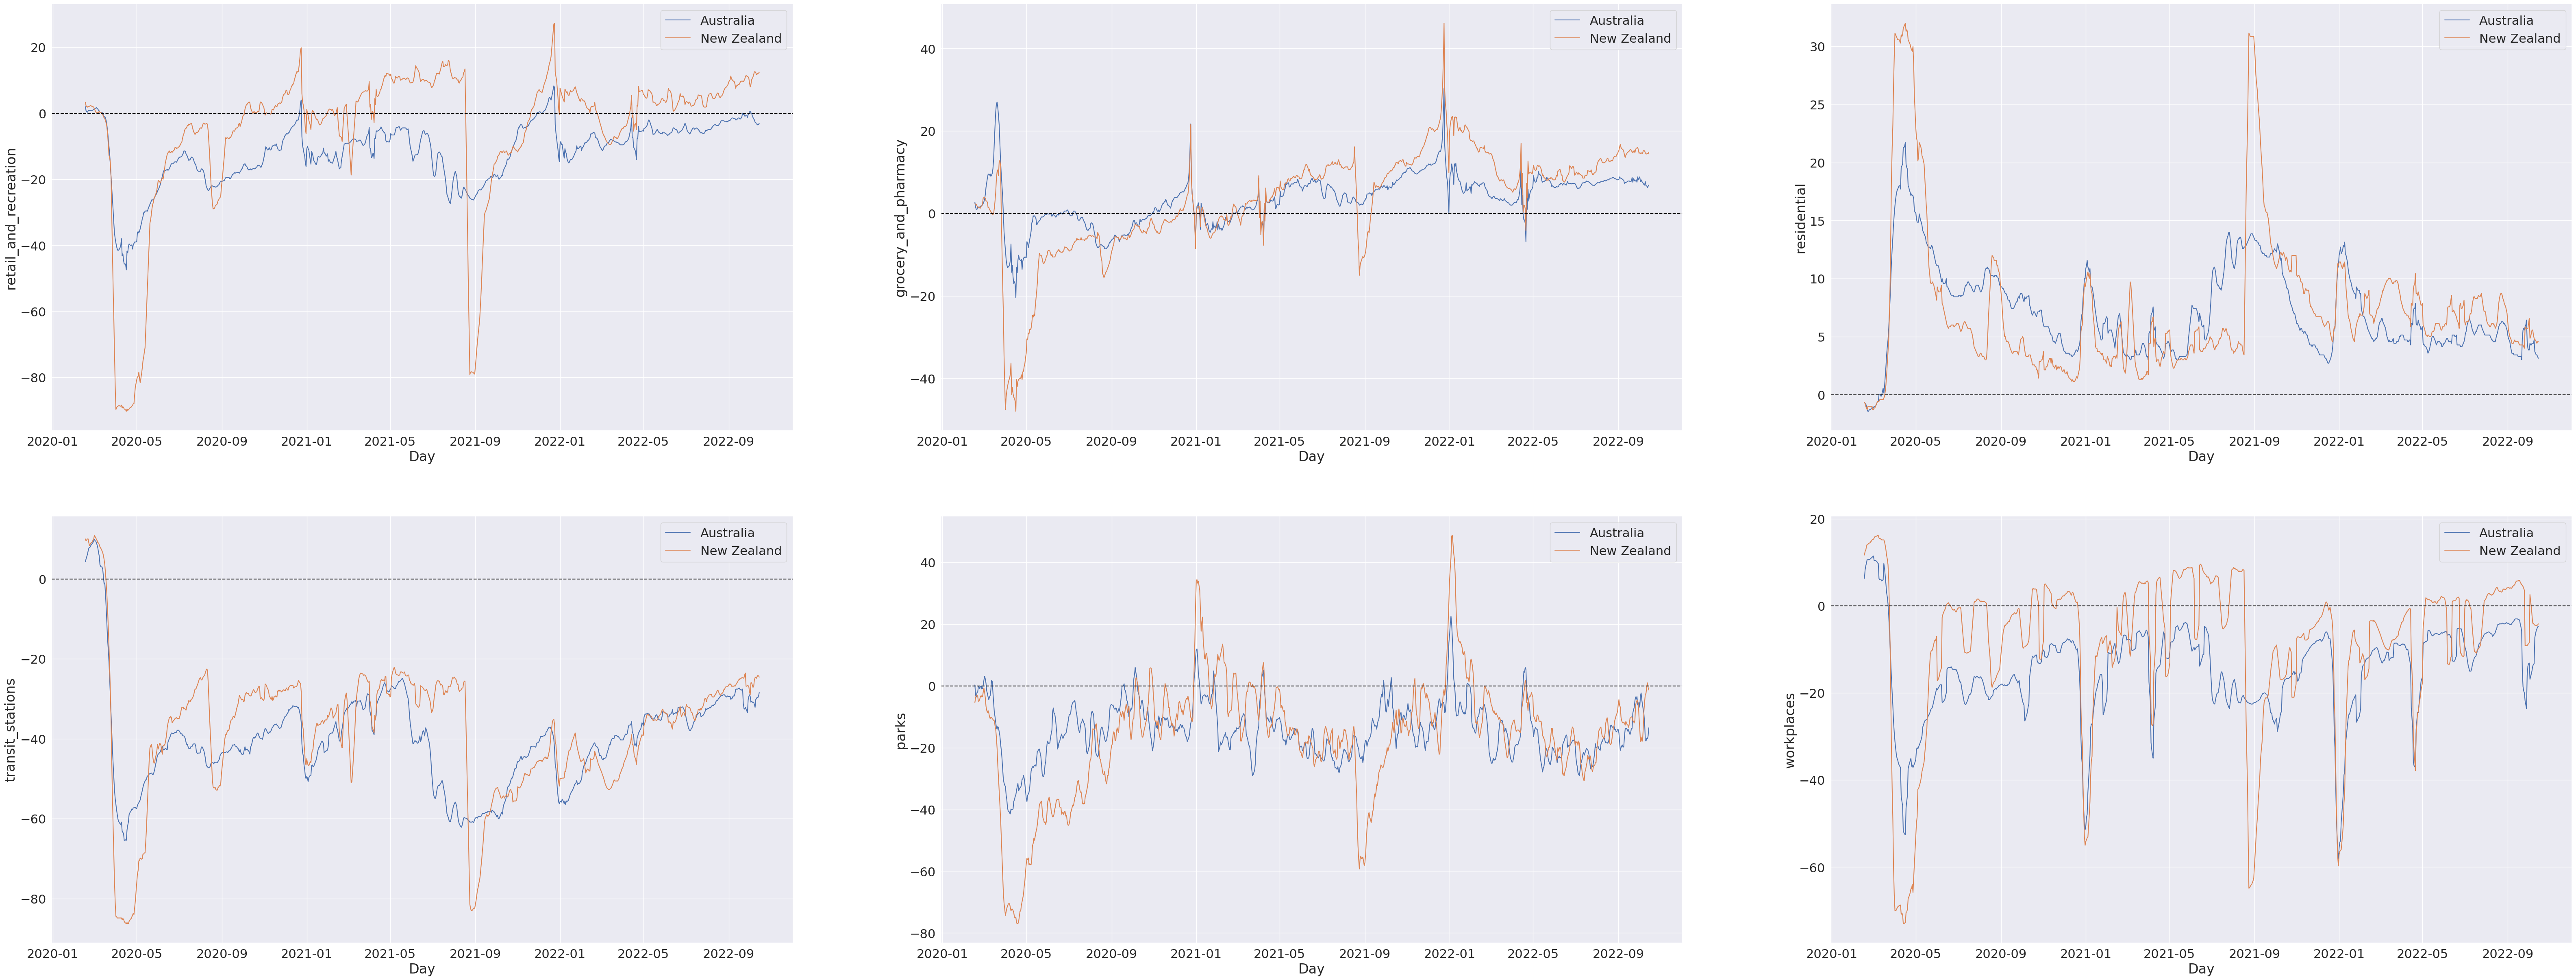

In [3]:
dataset_aus_newz = {
    "Australia": df_mobility_global_smo.filter((col('Entity') == 'Australia')),
    "New Zealand": df_mobility_global_smo.filter((col('Entity') == 'New Zealand'))
}

seab.set(font_scale=2)

figg, axx = plt.subplots(2, 3, figsize=(80, 30))

# Plotting the mobility data for Australia and New Zealand
plot_mobil_country_row = 0
plot_mobil_country_col = 0
for place in df_mobility_global_smo.columns[3:]:
    if plot_mobil_country_col == 3:
        plot_mobil_country_col = 0
        plot_mobil_country_row = 1
        
    for country, df_mob_glo_smo in dataset_aus_newz.items():
        seab.lineplot(x='Day', y=place, data=dataset_aus_newz[country].toPandas(), ax=axx[plot_mobil_country_row, plot_mobil_country_col], label=country)
        
    axx[plot_mobil_country_row, plot_mobil_country_col].axhline(y=0, color='black', linestyle='--')
    plot_mobil_country_col += 1

plt.show()

#### Creating new Subset Data from Community Mobility and Covid Cases for Australia and Italy

In [73]:
drop_columns_mobility = [
    'country_region_code',
    'sub_region_1',
    'sub_region_2',
    'metro_area',
    'iso_3166_2_code',
    'census_fips_code',
    'place_id'
]

drop_columns_covid_cases = [
    'location',
    'date',
    'total_cases',
    'new_cases'
]

"""          AUSTRALIA            """

# Datasets for mobility in Australia
df_mobil_2020_aus = spark.read.csv('./datasets/2020_AU_Region_Mobility_Report.csv', header=True, inferSchema=True)
df_mobil_2021_aus = spark.read.csv('./datasets/2021_AU_Region_Mobility_Report.csv', header=True, inferSchema=True)
df_mobil_2022_aus = spark.read.csv('./datasets/2022_AU_Region_Mobility_Report.csv', header=True, inferSchema=True)

# Dimension of the datasets for mobility in Australia
print(f'Dimension of mobility 2020 Australia: {df_mobil_2020_aus.toPandas().shape}')
print(f'Dimension of mobility 2021 Australia: {df_mobil_2021_aus.toPandas().shape}')
print(f'Dimension of mobility 2022 Australia: {df_mobil_2022_aus.toPandas().shape}')

# Combaining the three mobility datasets for Australia and removing unnecessary columns
dfs_mobil_aus = df_mobil_2020_aus.union(df_mobil_2021_aus)\
                            .union(df_mobil_2022_aus)\
                            .filter(col('sub_region_1').isNull())\
                            .drop(*drop_columns_mobility)

print(f'New dimension after filtering Australia: {dfs_mobil_aus.toPandas().shape}')

# Filtering Australia from the Covid Cases dataset. The date is set to 2022-10-15 to match the mobility dataset
dfs_cc_aus = dfs_cc.filter((col('location') == 'Australia') & (col('date') < '2022-10-15'))\
                    .drop(*[remove_col for remove_col in dfs_cc.columns if remove_col not in drop_columns_covid_cases])
print(f'Dimensions of dataset of Australia Covid Cases: {dfs_cc_aus.toPandas().shape}')

# Printing the columns of Community Mobility after filtering Australia and removing unnecessary columns
print('Columns of Community Mobility after filtering Australia and removing unnecessary columns:')
spark.createDataFrame(dfs_mobil_aus.columns, 'string').show(len(dfs_mobil_aus.columns), truncate=False)

# Printing the columns of Covid Cases after filtering Australia and removing unnecessary columns
print('Columns of Covid Cases after filtering Australia and removing unnecessary columns:')
spark.createDataFrame(dfs_cc_aus.columns, 'string').show(len(dfs_cc_aus.columns), truncate=False)

# Merging the two datasets: Community Mobility and Covid Cases for Australia on date and location columns
df_mobil_covid_cases_aus = dfs_mobil_aus.join(dfs_cc_aus, on=['date', 'location'], how='inner')
print(f'Dimension of merged dataset: {df_mobil_covid_cases_aus.toPandas().shape}')



"""          ITALY            """

# Datasets for mobility in Italy
df_mobil_2020_italy = spark.read.csv('./datasets/2020_IT_Region_Mobility_Report.csv', header=True, inferSchema=True)
df_mobil_2021_italy = spark.read.csv('./datasets/2021_IT_Region_Mobility_Report.csv', header=True, inferSchema=True)
df_mobil_2022_italy = spark.read.csv('./datasets/2022_IT_Region_Mobility_Report.csv', header=True, inferSchema=True)

# Dimension of the datasets for mobility in Italy
print(f'Dimension of mobility 2020 Italy: {df_mobil_2020_italy.toPandas().shape}')
print(f'Dimension of mobility 2021 Italy: {df_mobil_2021_italy.toPandas().shape}')
print(f'Dimension of mobility 2022 Italy: {df_mobil_2022_italy.toPandas().shape}')

# Combaining the three mobility datasets for Italy and removing unnecessary columns
dfs_mobil_italy = df_mobil_2020_italy.union(df_mobil_2021_italy)\
                            .union(df_mobil_2022_italy)\
                            .filter(col('sub_region_1').isNull())\
                            .drop(*drop_columns_mobility)

print(f'New dimension after filtering Italy: {dfs_mobil_italy.toPandas().shape}')

# Filtering Italy from the Covid Cases dataset. The date is set to 2022-10-15 to match the mobility dataset
dfs_cc_italy = dfs_cc.filter((col('location') == 'Italy') & (col('date') < '2022-10-15'))\
                    .drop(*[remove_col for remove_col in dfs_cc.columns if remove_col not in drop_columns_covid_cases])
print(f'Dimensions of dataset of Italy Covid Cases: {dfs_cc_italy.toPandas().shape}')

# Printing the columns of Community Mobility after filtering Italy and removing unnecessary columns
print('Columns of Community Mobility after filtering Italy and removing unnecessary columns:')
spark.createDataFrame(dfs_mobil_italy.columns, 'string').show(len(dfs_mobil_italy.columns), truncate=False)

# Printing the columns of Covid Cases after filtering Italy and removing unnecessary columns
print('Columns of Covid Cases after filtering Italy and removing unnecessary columns:')
spark.createDataFrame(dfs_cc_italy.columns, 'string').show(len(dfs_cc_italy.columns), truncate=False)

# Merging the two datasets: Community Mobility and Covid Cases for Italy on date and location columns
df_mobil_covid_cases_italy = dfs_mobil_italy.join(dfs_cc_italy, on=['date', 'location'], how='inner')
print(f'Dimension of merged dataset: {df_mobil_covid_cases_italy.toPandas().shape}')

Dimension of mobility 2020 Australia: (85330, 15)
Dimension of mobility 2021 Australia: (104926, 15)
Dimension of mobility 2022 Australia: (82730, 15)
New dimension after filtering Australia: (974, 8)
Dimensions of dataset of Australia Covid Cases: (1016, 4)
Columns of Community Mobility after filtering Australia and removing unnecessary columns:
+--------------------------------------------------+
|value                                             |
+--------------------------------------------------+
|country_region                                    |
|date                                              |
|retail_and_recreation_percent_change_from_baseline|
|grocery_and_pharmacy_percent_change_from_baseline |
|parks_percent_change_from_baseline                |
|transit_stations_percent_change_from_baseline     |
|workplaces_percent_change_from_baseline           |
|residential_percent_change_from_baseline          |
+--------------------------------------------------+

Columns of Cov

In [ ]:
pd_mobil_aus = dfs_mobil_aus.toPandas()

print(f'Dimension of mobility dataset combined (2020, 2021, 2022) Australia: {pd_mobil_aus.shape}')

# Printing Community mobility Australia
mpl.rcParams['font.size'] = 28
fig, axs = plt.subplots(8, 1, figsize=(80, 80), sharex=True, sharey=False)

axs[0].set_ylabel('retail_and_recreation')
axs[0].bar(pd_mobil_aus['date'], pd_mobil_aus['retail_and_recreation_percent_change_from_baseline'])

axs[1].set_ylabel('grocery_and_pharmacy')
axs[1].bar(pd_mobil_aus['date'], pd_mobil_aus['grocery_and_pharmacy_percent_change_from_baseline'])

axs[2].set_ylabel('parks')
axs[2].bar(pd_mobil_aus['date'], pd_mobil_aus['parks_percent_change_from_baseline'])

axs[3].set_ylabel('transit_stations')
axs[3].bar(pd_mobil_aus['date'], pd_mobil_aus['transit_stations_percent_change_from_baseline'])

axs[4].set_ylabel('workplaces')
axs[4].bar(pd_mobil_aus['date'], pd_mobil_aus['workplaces_percent_change_from_baseline'])

axs[5].set_ylabel('residential')
axs[5].bar(pd_mobil_aus['date'], pd_mobil_aus['residential_percent_change_from_baseline'])

axs[6].set_ylabel('new_cases')
axs[6].bar(dfs_cc_aus['date'], dfs_cc_aus['new_cases'])
axs[6].set_yscale('log')

axs[7].set_ylabel('new_deaths')
axs[7].bar(dfs_cc_aus['date'], dfs_cc_aus['new_deaths'])
axs[7].set_yscale('log')

for hoz_line in axs.flat:
    hoz_line.axhline(y=0, color='r', linestyle='-')

# Four waves of COVID-19 in Australia: Wave 1, Wave 2, Delta wave, Omicron wave
for idx, span in enumerate(axs.flat):
    axis_x_print = [15, 59, 35, 13, 15, 32, 50000 , 130]
    font_size = 32
    span.axvspan(datetime(2020, 3, 1), datetime(2020, 5, 15), color='red', alpha=0.5)
    span.text(datetime(2020, 3, 1), axis_x_print[idx], 'Wave 1', fontsize=font_size, color='black')
    span.axvspan(datetime(2020, 6, 1), datetime(2020, 11, 30), color='red', alpha=0.5)
    span.text(datetime(2020, 6, 1), axis_x_print[idx], 'Wave 2', fontsize=font_size, color='black')
    span.axvspan(datetime(2021, 7, 1), datetime(2021, 12, 15), color='red', alpha=0.5)
    span.text(datetime(2021, 7, 1), axis_x_print[idx], 'Delta wave', fontsize=font_size, color='black')
    span.axvspan(datetime(2022, 1, 1), datetime(2022, 8, 31), color='red', alpha=0.5)
    span.text(datetime(2022, 1, 1), axis_x_print[idx], 'Omicron wave', fontsize=font_size, color='black')

# Pricipal lockdowns of Australia
for span in axs.flat:
    span.axvspan(datetime(2020, 3, 23), datetime(2020, 5, 15), color='black', alpha=0.1)
    span.axvspan(datetime(2020, 7, 9), datetime(2020, 10, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 1, 8), datetime(2021, 2, 26), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 6, 28), datetime(2021, 7, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 8, 5), datetime(2021, 8, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 8, 31), datetime(2021, 9, 23), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 10, 15), datetime(2021, 10, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 11, 26), datetime(2021, 12, 15), color='black', alpha=0.1)

plt.show()

